# Проект по A/B-тесту

Проект для крупного интернет-магазина. Вместе с маркетологом подготовлены 9 гипотез по увеличению выручки. Нужно провести приоритизацию гипотез и провести А/В-тест с анализом результатов.

**Цель:** приоритизация гипотез по увеличению выручки, проведения A/B-теста и формирование выводов и рекомендация для дальнейшей тактики маркетингового отдела.

**Данные представлены в трёх файлах:**

Первый файл `hypothesis` с гипотезами и их оценкой по ряду показателей предоставлен маркетологом для приоритизации:
- Hypothesis — краткое описание гипотезы;
- Reach — охват пользователей по 10-балльной шкале;
- Impact — влияние на пользователей по 10-балльной шкале;
- Confidence — уверенность в гипотезе по 10-балльной шкале;
- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы

Два других файла `orders` и `visitors` - данные после проведения A/B-теста:
- transactionId — идентификатор заказа;
- visitorId — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ.

- date — дата;
- group — группа A/B-теста;
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста

**Ход исследования:**
1. Приоритизация гипотез
2. Ознакомление с результатами A/B-теста, предобработка данных
3. Построение графиков по кумулятивным данным с разбивкой по группам
4. Обработка аномальных значений
5. Проверка статистической значимости сырых и очищенных от выбросов данных
6. Формирование выводов
7. Практические рекомендации

## Часть 1. Приоритизация гипотез.

Будем применять два фреймворка для оценки степени важности: ICE - без учета охвата изменения и RICE - с учетов охвата изменения.

In [260]:
# импорт нужных библиотек
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
import datetime as dt

In [261]:
# добавим настройку, чтобы отображался текст гипотез полностью
pd.set_option('display.max_colwidth', None)

In [262]:
# для начала ознакомимся с файлом с гипотезами
try: 
    hypothesis = pd.read_csv('hypothesis.csv')
except:
    hypothesis = pd.read_csv('/datasets/hypothesis.csv')

hypothesis

In [263]:
# применим фреймворк ICE для приоритизации и посмотрим на результат

hypothesis['ICE'] = round(hypothesis['Impact'] 
                     *hypothesis['Confidence']
                     / hypothesis['Efforts'], 1)
hypothesis[['Hypothesis', 'ICE']].sort_values(by='ICE', ascending=False)

Мы видим, что по рейтингу ICE лидирует гипотеза о запуске акции в День рождения. Однако, помним, что ICE не учитывает охват пользователей. Поэтому теперь проверим наши гипотезы с помощью фреймворка RICE:

In [264]:
hypothesis['RICE'] = (hypothesis['Reach']
                      *hypothesis['Impact']
                      *hypothesis['Confidence']
                      / hypothesis['Efforts']
                     )
hypothesis[['Hypothesis', 'ICE', 'RICE']].sort_values(by='RICE', ascending=False)

А если учитывать еще и охват пользователей, абсолютным лидером среди гипотез становится форма и сбор базы для email-рассылок. Эта гипотеза была на третьем месте по шкале ICE. \
Для наглядности и красоты построим барплот по RICE:

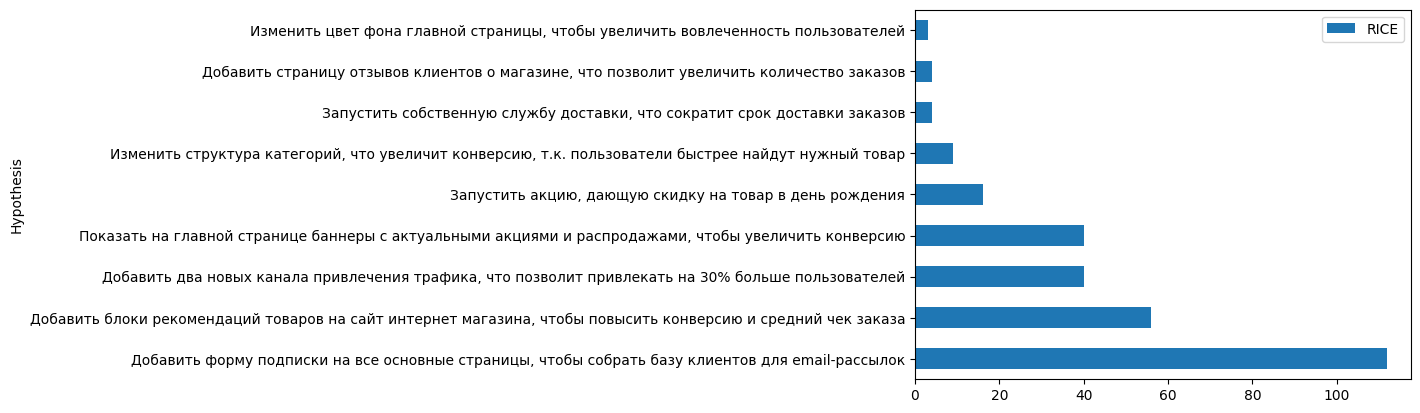

In [265]:
hypothesis[['Hypothesis', 'RICE']].sort_values(by='RICE', ascending=False).set_index('Hypothesis').plot(kind='barh');

**Вывод:** \
Для выбора из 9 гипотез было применено два фреймворка: ICE и RICE. Но были получены различные результаты. По оценке ICE лидером стал запуск акции в честь Дня рождения (гипотеза 8), а по оценке RICE лидирует форма для сбора базы для email-рассылок(гипотеза 7). Такое отличие связано с тем, что при использовании ICE не учитывается охват пользователей. Акция в честь Дня рождения - дешевле, приносит результат, дает уверенность в эффекте, однако такое обновление очень узконаправленно. \
А вот форма для email-рассылок как раз имеет максимальных охват из представленных гипотез. \
Если провести прямой сравнение этих двух гипотез по оценкам, мы увидим, что они сравнимы по затратам, при этом по уверенности и силе влияния email-рассылки немного отстают от акции к Дню рождения, однако уверенно вырываются за счёт широкого охвата.

Думаю, если проводить тест гипотезы 8, то придется довольно долго ждать результат, так как набрать нужное количество людей будет сложнее. \
Допустим, что после полученного результата мы посовещались со старшими коллегами и решили запустить тест гипотезы 7 - сбор базы клиентов для email-рассылок.

## Часть 2. Анализ результатов A/B-теста

### Ознакомление с данными, предобработка
После проведения теста получены результаты по двум группам. Для начала ознакомимся с датасетами, содержащими результаты.

In [266]:
try:
    orders = pd.read_csv('orders.csv')
    visitors = pd.read_csv('visitors.csv')
except:
    orders = pd.read_csv('/datasets/orders.csv')
    visitors = pd.read_csv('/datasets/visitors.csv')

In [267]:
display(orders.head(10))
visitors.head(10)

In [268]:
# посмотрим на типы данных

display(orders.dtypes)
visitors.dtypes

Ага, приведем даты к нужному типу данных:

In [269]:
orders['date'] = orders['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

visitors['date'] = visitors['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

display(orders.dtypes)
visitors.dtypes

In [270]:
# теперь оценим, есть ли пропуски в данных, вдруг что-то пошло не так и некорректно записалось
display(orders.isna().sum())
visitors.isna().sum()

In [271]:
# и посмотрим, нет ли явных дубликатов
display(orders.duplicated().sum())
visitors.duplicated().sum()

Пропусков и дубликатов нет, что не может не радовать. Однако, я для удобства хочу перевести названия столбцов к змеиному регистру:

In [272]:
orders = orders.rename(columns={'transactionId': 'transaction_id', 'visitorId': 'visitor_id'})
orders.columns

Вот, теперь с датасетом приятно работать. Посмотрим теперь, корректно ли сформированы группы, нет ли пользователей, которые попали в обе группы.

In [273]:
# для начала посмотрим количество пользователей в каждой группе
users_group = (orders.groupby('group', as_index=False)
               .agg({'visitor_id': 'nunique'})
              )
users_group

In [274]:
# теперь сравним айди посетителей в двух группах
group_a = orders[orders['group'] == 'A']
group_b = orders[orders['group'] == 'B']
double = group_a[group_a['visitor_id'].isin(group_b['visitor_id'])]['visitor_id']
print('Количество покупок совпавших пользователей:', len(double))
print('Количество совпавших пользователей:', len(double.unique()))

Получается, 58 посетителей, совершивших покупку, попадали то в одну группу, то в другую. При этом неоднократно, тк покупок больше, чем самих таких пользователей.

**Выводы:** \
На данном этапе мы ознакомились с данными, полученными при проведении A/B-теста, привели даты к нужному типу, а названия столбцов к змеиному регистру для удобства. Пропусков и дубликатов не обнаружилось.\
Однако обнаружены пользователи, попавшие в обе группы сразу. Это может быть связано с некорреттной настройкой трафика, может быть, предварительно не проведен A/A-тест. Нужно подойти к этому вопросу внимательнее. Я решила не удалять эти данные из исследования, так как во второй таблице по посетителям учтены эти пользователи и мы не можем удалить их оттуда, после удаления дублирующих пользователей могут быть неверные результаты (например, по количеству заказов на посетителя).

### График кумулятивной выручки по группам

Для того, чтобы более наглядно оценить выручку в обеих группах, представим ее в виде графика для каждой группы с разбивкой по дням:

In [275]:
# соберем уникальные комбинации даты и группы
dates_groups = orders[['date', 'group']].drop_duplicates()

# теперь получим данные о заказах до каждой даты, найдем максимальную дату, найдем количество 
# уникальных заказов и пользователей, совершивших заказ
orders_aggregated = dates_groups.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transaction_id': 'nunique',
            'visitor_id': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

# также соберем данные по суммарным визитам на сайт до конкретной даты
visitors_aggregated = dates_groups.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])

In [276]:
# теперь объединим полученные данные и переименуем столбцы
cumulative_data = orders_aggregated.merge(
    visitors_aggregated, left_on=['date', 'group'], right_on=['date', 'group']
)
cumulative_data.columns = [
    'date',
    'group',
    'orders',
    'buyers',
    'revenue',
    'visitors',
]

In [277]:
# посмотрим на результат 
cumulative_data.head(10)

Отлично, у нас в таблице собраны данные по кумулятивной выручке и пользователям для определенной даты в каждой группе.

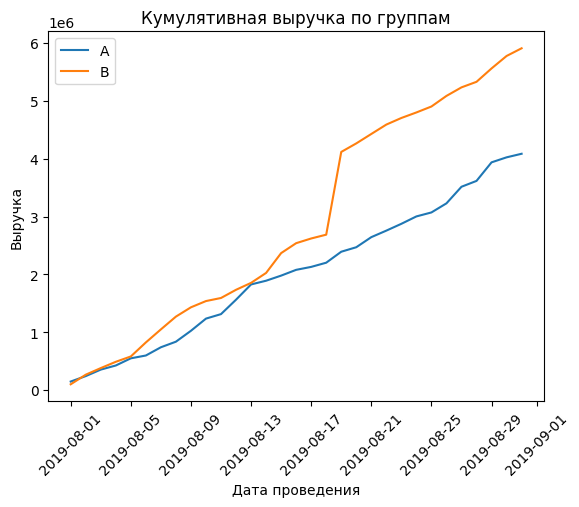

In [278]:
# теперь соберем данные для групп А и В в отдельные датафреймы и построим график по ним:

cumulative_revenueA = cumulative_data[cumulative_data['group']=='A'][['date', 'revenue', 'orders']]

cumulative_revenueB = cumulative_data[cumulative_data['group']=='B'][['date', 'revenue', 'orders']]

plt.plot(cumulative_revenueA['date'],
         cumulative_revenueA['revenue'],
        label='A',
        );

plt.plot(cumulative_revenueB['date'],
         cumulative_revenueB['revenue'],
        label='B');
plt.legend();
plt.xticks(rotation=45);
plt.title('Кумулятивная выручка по группам');
plt.xlabel('Дата проведения');
plt.ylabel('Выручка');
plt.figure(figsize=(10,6));
plt.show();

**Вывод:** \
Как мы видим по графику, во второй половине теста группа B резко вырвалась вперед по выручке и до конца теста неуклонно опережала и росла. Позже выясним, связаны ли такие результаты с наличием аномально больших заказов. Пока можем это просто предположить из-за резкого скачка.

### График кумулятивного среднего чека по группам

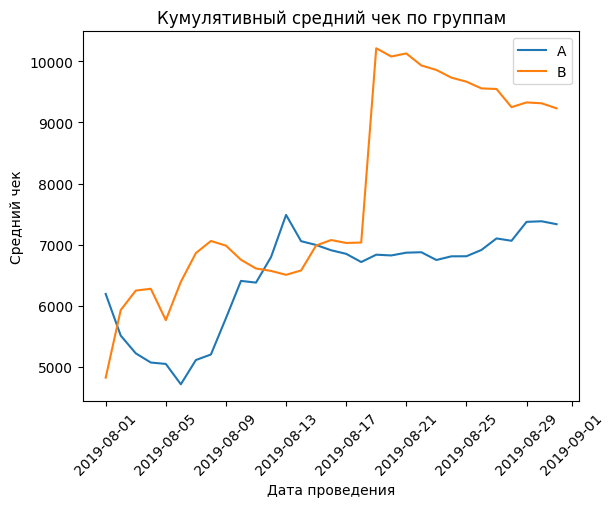

In [279]:
# так как нужные данные уже готовы в прошлом шаге, построим график
plt.plot(cumulative_revenueA['date'],
        cumulative_revenueA['revenue']/cumulative_revenueA['orders'],
        label = 'A');

plt.plot(cumulative_revenueB['date'],
        cumulative_revenueB['revenue']/cumulative_revenueB['orders'],
        label = 'B');
plt.legend();
plt.xticks(rotation=45);
plt.title('Кумулятивный средний чек по группам');
plt.xlabel('Дата проведения');
plt.ylabel('Средний чек');
plt.figure(figsize=(10,6));
plt.show();

**Вывод:** \
В то же время, что и выручка (17 августа), средний чек в группе B резко пошел вверх относительно группы A, но затем плавно снижался и почти зафиксировался к концу теста. Такие изменения могут говорить о том, что в группе B присутствуют аномально крупные заказы, которые могут искажать результаты.

### График относительного изменения среднего чека группы B к группе A

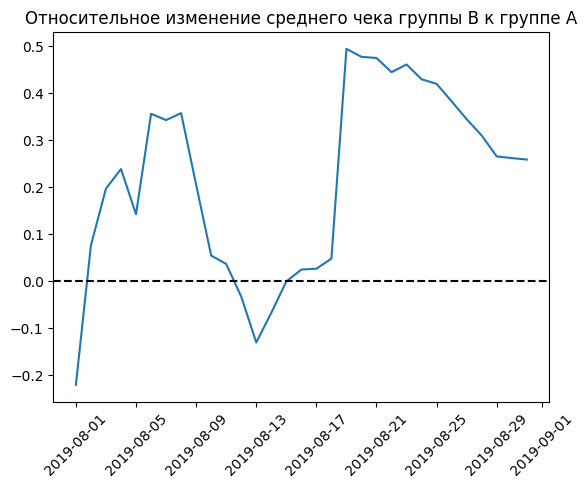

In [280]:
# объединим таблицы с данными по каждой группе и добавим суффиксы, чтобы "пометить" группу
merged_cumulative_revenue = cumulative_revenueA.merge(
    cumulative_revenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B']
) 
# построим график по полученным данным и добавим пунктирную линию на уровне 0 - то есть отсутсвия отличий между группами
plt.plot(merged_cumulative_revenue['date'],
        (merged_cumulative_revenue['revenueB']/merged_cumulative_revenue['ordersB'])
         /(merged_cumulative_revenue['revenueA']/merged_cumulative_revenue['ordersA']) - 1
        );
plt.axhline(y=0, color='black', linestyle='--');
plt.xticks(rotation=45);
plt.title('Относительное изменение среднего чека группы B к группе A');

**Вывод:** \
И снова мы видим, что с 17 августа средний чек группы B резко вырвался вперед после резкого провала, затем плавно пошел вниз. Такие скачки подтверждают наши предположения об аномально крупных заказах.

### График кумулятивного среднего количества заказов на посетителя по группам

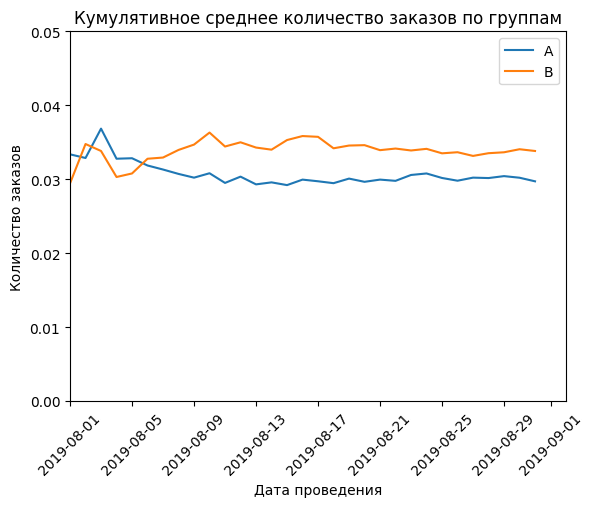

In [281]:
# создадим столбец с конверсией по нашим данным
cumulative_data['conversion'] = cumulative_data['orders'] / cumulative_data['visitors']
# разобьем по группам
cumulative_dataA = cumulative_data[cumulative_data['group']=='A']
cumulative_dataB = cumulative_data[cumulative_data['group']=='B']
# построим графики по группам
plt.plot(cumulative_dataA['date'], cumulative_dataA['conversion'], label='A');
plt.plot(cumulative_dataB['date'], cumulative_dataB['conversion'], label='B');
plt.legend();
# добавим масштаб
plt.axis([dt.datetime(2019,8,1), dt.datetime(2019,9,2), 0, 0.05]);
plt.xticks(rotation=45);
plt.title('Кумулятивное среднее количество заказов по группам');
plt.xlabel('Дата проведения');
plt.ylabel('Количество заказов');
plt.figure(figsize=(10,6));
plt.show();

**Вывод:** \
Среднее количество заказов на пользователя испытывало совсем незначительные колебания в пределах 1%, при этом в группе B количество стабильно примерно с 4 дня эксперимента было выше, чем в группе A. Так как колебаний нет, а резльтат стабилен, можно сказать, что количество заказов в группе B зафикисировалась. Посмотрим для наглядности еще на один график

### График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A

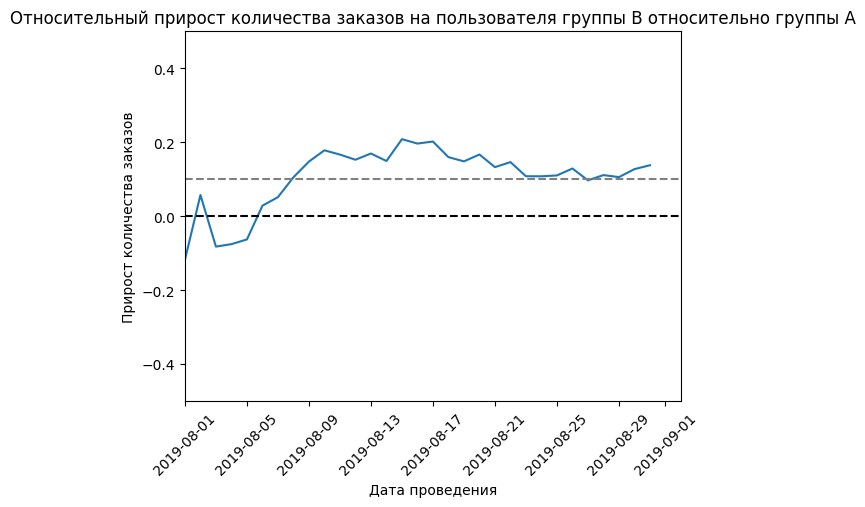

In [282]:
# объединим данные из двух таблиц
merged_cumulative_conversions = cumulative_dataA[['date', 'conversion']].merge(cumulative_dataB[['date', 'conversion']], 
                                                                               left_on='date', right_on='date', 
                                                                               how='left', suffixes=['A', 'B'])
# построим график
plt.plot(merged_cumulative_conversions['date'], 
         merged_cumulative_conversions['conversionB']/merged_cumulative_conversions['conversionA']-1, 
        );

plt.title('Относительный прирост количества заказов на пользователя группы B относительно группы A');
# добавим две пунктирных линии, на 0 - отсутствие изменений, и на 0.1 - изменения конверсии на 10%
plt.axhline(y=0, color='black', linestyle='--');
plt.axhline(y=0.1, color='grey', linestyle='--');
plt.axis([dt.datetime(2019,8,1), dt.datetime(2019,9,2), -0.5, 0.5]);
plt.xticks(rotation=45);
plt.xlabel('Дата проведения');
plt.ylabel('Прирост количества заказов');
plt.figure(figsize=(10,6));
plt.show();

**Вывод:** \
По этому графику хорошо видно, что среднее количество заказов на пользователя в группе B стабильно росло, к середине теста достигло даже прироста в 20%, однако затем стало постепенно снижаться, но всё равно стабильно выше этого показателя в группе A и держится на уровне 10%. Нет данных, какое минимальное изменение считать целевым, но мы можем отметить относительную стабильность и хороший уровень количества заказов в группе B. Изменения в 10% могут быть ощутимыми. \
Но перед тем, как делать окончательный вывод, стоит проверить наличие выбросов, которые могут искажать картину. Ведь могут быть пользователи, которые совершили 5-10-15 заказов среди среднего количества в 1-2 заказа. 

### Распределение количества заказов на пользователя

In [283]:
# для начала сгруппируем данные по пользователям и найдем количество уникальных заказов

orders_by_users = (orders.groupby('visitor_id', as_index=False)
                   .agg({'transaction_id': 'nunique'})
                  )
orders_by_users.columns = ['visitor_id', 'orders']
orders_by_users.sort_values(by='orders', ascending=False).head(5)

Да, уже видно любителей заказывать онлайн, но для наглядности построим точечную диаграмму

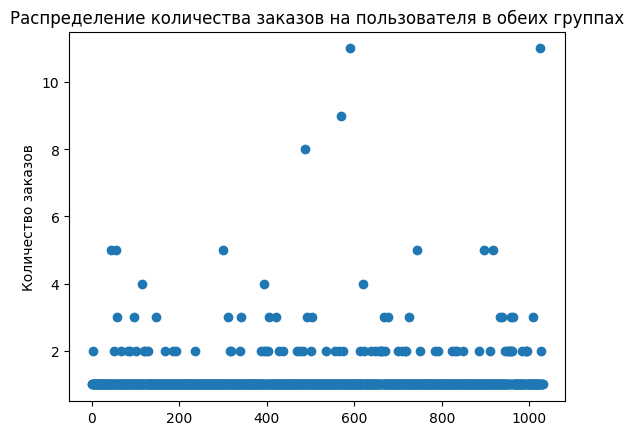

In [284]:
# зададим параметры для оси х
x_values = pd.Series(range(0, len(orders_by_users)))
# построим график
plt.scatter(x_values, orders_by_users['orders']);
plt.title('Распределение количества заказов на пользователя в обеих группах')
plt.ylabel('Количество заказов');
plt.figure(figsize=(10,6));
plt.show()

Не так много пользователей, совершивших больше 2-3 заказов. Найдем 95 и 99 перцентили, чтобы точнее определиться с границами выбросов.

In [285]:
np.percentile(orders_by_users['orders'], [95, 99])

Не более 5% пользователей совершили более 2 заказов и лишь не более 1% пользователей совершили более 4 заказов. Возьмем верхнюю границу в 3 заказа.

**Вывод:** \
Изучив значения перцентилей по количеству заказов на пользователя, мы определились, что верхней границей для фильтрации выбросов будет показатель 3 и более заказа.

### Распределение стоимостей заказов

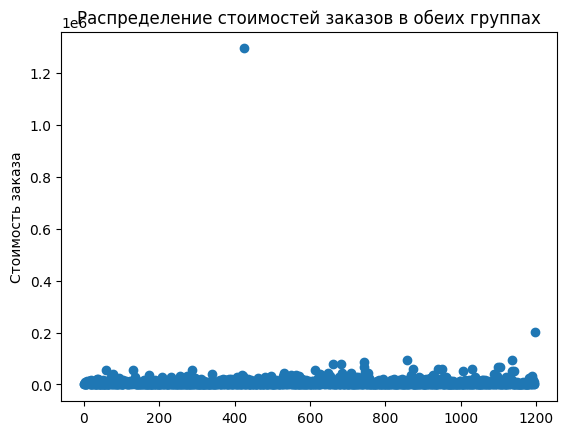

In [286]:
# зададим значения для оси х
x_values = pd.Series(range(0, len(orders['revenue'])))
# построим точечную диаграмму по стоимости заказов
plt.scatter(x_values, orders['revenue']);
plt.title('Распределение стоимостей заказов в обеих группах')
plt.ylabel('Стоимость заказа');
plt.figure(figsize=(10,6));
plt.show()

Так как есть аномально дорогие заказы - более миллиона - сделаем график без учёта этих выбросов, чтобы точнее оценить распределение.

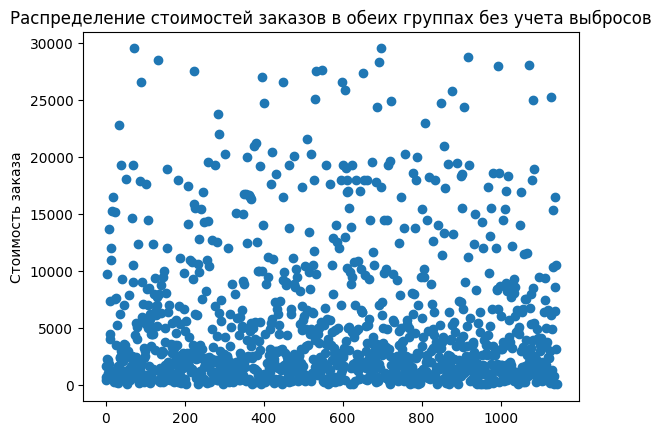

In [287]:

# зададим значения для оси х
x_values = pd.Series(range(0, len(orders[orders['revenue'] < 30000]['revenue'])))
# построим точечную диаграмму по стоимости заказов
plt.scatter(x_values, orders[orders['revenue'] < 30000]['revenue']);
plt.title('Распределение стоимостей заказов в обеих группах без учета выбросов')
plt.ylabel('Стоимость заказа');
plt.figure(figsize=(10,6));
plt.show()

Так более наглядно видно, что основная масса заказов сосредоточена до 20 тысяч рублей. Теперь нужно оценить 95 и 99 перцентили, чтобы определить верхнюю границу более точно. 

In [288]:
np.percentile(orders['revenue'], [95, 99])

Не более 5% заказов были стоимостью более 28 тысяч, а заказов стоимостью выше 58 тысяч и вовсе не более 1%. Примем за верхнюю границу 30 тысяч.

**Вывод:** \
Изучив перцентили стоимости заказов, мы определили верхнюю границу для фильтрации выбросов в 30 тысяч.
Теперь можно перейти к оценке статистически значимых отличий и определить влияние выбросов

### Статистическая значимость различий в группах A и B по "сырым" данным с выбросами

Для начала проверим гипотезу о среднем количестве заказов на пользователя. Нулевая гипотеза - отличий между группами А и В по среднему количеству заказов на посетителя нет, альтернативная гипотеза - различия есть.\
Уровень значимости alpha установим 0.05, так как эксперимент был один, поправки не требуются.

In [289]:
alpha = 0.05

In [290]:
# соберем пользователей из группы А по дате посещения
visitorsA_daily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsA_daily.columns = ['date', 'visitors_per_dateA']

# создадим таблицу с кумулятивным количеством пользователей по дням из группы А
visitorsA_cummulative = visitorsA_daily.apply(
    lambda x: visitorsA_daily[visitorsA_daily['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_dateA': 'sum'}
    ),
    axis=1,
)
visitorsA_cummulative.columns = ['date', 'visitors_cummulativeA']

# то же самое для группы В
visitorsB_daily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsB_daily.columns = ['date', 'visitors_per_dateB']

visitorsB_cummulative = visitorsB_daily.apply(
    lambda x: visitorsB_daily[visitorsB_daily['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_dateB': 'sum'}
    ),
    axis=1,
)
visitorsB_cummulative.columns = ['date', 'visitors_cummulativeB']

# теперь сделаем таблицы с кумулятивными выручкой и заказами по дням для обеих групп
ordersA_daily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersA_daily.columns = ['date', 'orders_per_dateA', 'revenue_per_dateA']

ordersA_cummulative = ordersA_daily.apply(
    lambda x: ordersA_daily[ordersA_daily['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_dateA': 'sum', 'revenue_per_dateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersA_cummulative.columns = [
    'date',
    'orders_cummulativeA',
    'revenue_cummulativeA',
]

ordersB_daily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersB_daily.columns = ['date', 'orders_per_dateB', 'revenue_per_dateB']

ordersB_cummulative = ordersB_daily.apply(
    lambda x: ordersB_daily[ordersB_daily['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_dateB': 'sum', 'revenue_per_dateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersB_cummulative.columns = [
    'date',
    'orders_cummulativeB',
    'revenue_cummulativeB',
]

# объединим полученные данные
data = (
    ordersA_daily.merge(
        ordersB_daily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersA_cummulative, left_on='date', right_on='date', how='left')
    .merge(ordersB_cummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsA_daily, left_on='date', right_on='date', how='left')
    .merge(visitorsB_daily, left_on='date', right_on='date', how='left')
    .merge(visitorsA_cummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsB_cummulative, left_on='date', right_on='date', how='left')
)

#создадим таблицы с пользователями, а для тех, кто заказывал хотя бы 1 раз, укажем количество заказов
orders_by_usersA = (
    orders[orders['group'] == 'A'].groupby('visitor_id', as_index=False)
        .agg({'transaction_id':pd.Series.nunique})
) 
orders_by_usersA.columns = ['user_id', 'orders']

orders_by_usersB = (
    orders[orders['group'] == 'B'].groupby('visitor_id', as_index=False)
        .agg({'transaction_id':pd.Series.nunique})
) 
orders_by_usersB.columns = ['user_id', 'orders']

# сохраним выборку с количеством заказов для каждого пользователя, в том числе и нули
sampleA = (
    pd.concat([orders_by_usersA['orders'], 
               pd.Series(0, index=np.arange(data['visitors_per_dateA'].sum() - 
                                            len(orders_by_usersA['orders'])), name='orders')],
               axis=0) 
)
sampleB = (
    pd.concat([orders_by_usersB['orders'], 
               pd.Series(0, index=np.arange(data['visitors_per_dateB'].sum() - 
                                            len(orders_by_usersB['orders'])), name='orders')],
               axis=0)
) 
# теперь выведем p-value по критерию Манна-Уитни и среднее отличие в двух группах
print('P-value: {0:.5f}'.format(st.mannwhitneyu(sampleA, sampleB)[1]))
print('Среднее отличие по группам: {0:.3f}'.format(sampleB.mean() / sampleA.mean() - 1))

if st.mannwhitneyu(sampleA, sampleB)[1] < alpha:
    print('Отвергаем нулевую гипотезу: отличия между группами по количеству заказов есть')
else:
    print('Не удалось отвергнуть нулевую гипотезу: по количеству заказов группы не отличаются')

**Вывод:** \
Таким образом, есть статистически значимые отличия по количеству заказов на пользователя среди двух групп. При этом в среднем количество заказов в группе В превышало количество заказов в группе А на 13.8%. \
Напомню, что это анализ по сырым данным, нужно будет сравнить очищенные данные, ведь пользователи с 11, 9 и даже 5 заказами могут искажать общую картину.

Теперь посчитаем, есть ли статистически значимые отличия по среднему чеку по двум группам.\
Нулевая гипотеза - отличий между группами А и В по среднему чеку нет. Альтернативная - отличия есть.

In [291]:
print('P-value: {0:.5f}'.format(st.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('Среднее отличие по среднему чеку в группах:{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

if st.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1] < alpha:
    print('Отвергаем нулевую гипотезу: отличия между группами по среднему чеку есть')
else:
    print('Не можем отвергнуть нулевую гипотезу: отличий между группами по среднему чеку нет')

**Вывод:** \
Несмотря на то, что средний чек в группе В превышает средний чек в группе А в среднем на 25.9%, эти отличия статистически не значимы. Это результаты по сырым данным, теперь изучим показатели по очищенным данным.

### Статистическая значимость различий в группах A и B по "очищенным" данным

Для начала подготовим датасеты с очищенными от аномалий данными.
Выше мы определили верхние границы, поэтому будем исключать пользователей, которые совершили от 3 и более заказов и заказы на сумму более 30 тысяч.

In [292]:
# сделаем срез и сохраним в отдельную таблицу пользователей с аномальными заказами
users_with_many_orders = pd.concat(
    [orders_by_usersA[orders_by_usersA['orders'] > 2]['user_id'],
    orders_by_usersB[orders_by_usersB['orders'] > 2]['user_id']],
    axis=0
) 

users_with_expensive_orders = orders[orders['revenue'] > 30000]['visitor_id']

abnormal_users = (
    pd.concat([users_with_many_orders, users_with_expensive_orders], axis=0)
    .drop_duplicates()
    .sort_values()
) 

# теперь сделаем срезы из полученных ранее датасетов, исключив пользователей с аномальными заказами

sampleA_filtered = pd.concat(
    [
        orders_by_usersA[np.logical_not(orders_by_usersA['user_id'].isin(abnormal_users))]['orders'],
        pd.Series(0, index=np.arange(data['visitors_per_dateA'].sum() - len(orders_by_usersA['orders'])), name = 'orders')
    ], axis=0
) 

sampleB_filtered = pd.concat(
    [
        orders_by_usersB[np.logical_not(orders_by_usersB['user_id'].isin(abnormal_users))]['orders'],
        pd.Series(0, index=np.arange(data['visitors_per_dateB'].sum() - len(orders_by_usersB['orders'])), name = 'orders')
    ], axis=0
) 

Теперь можно приступить к проверке очищенных данных. Примем за нулевую гипотезу - что отличий по количеству заказов на пользователя в группах A и B в очищенных данных нет. Альтернативная гипотеза - отличия есть.

In [293]:

print('P-value: {0:.5f}'.format(st.mannwhitneyu(sampleA_filtered, sampleB_filtered)[1]))
print('Среднее отличие по количеству заказов {0:.3f}'.format(sampleB_filtered.mean() / sampleA_filtered.mean() - 1))
if st.mannwhitneyu(sampleA_filtered, sampleB_filtered)[1] < alpha:
    print('Отвергаем нулевую гипотезу: количество заказов на пользователя в очищенных данных отличается в группах A и B')
else:
    print('Не можем отвергнуть нулевую гипотезу, отличий по количеству заказов на посетителя нет')

**Вывод:** \
Ага, даже после удаления аномальных значений статистически значимые отличия сохраняются. При этом количество заказов в группе B выше в среднем на 17.2%. Получается, группа B, действительно, показывает себя лучше и дело не в аномалиях.

Теперь перейдем к проверке среднего чека в группах по очищенным данным. Нулевая гипотеза - различий по среднему чеку между группами в очищенных данных нет. Альтернативная гипотеза - отличия есть.

In [294]:
pvalue = (st.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormal_users)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormal_users)),
                )
            ]['revenue'],
        )[1]
         ) 

print('P-value: {0:.5f}'.format(pvalue))

print(
    "Среднее отличие по среднему чеку в очищенных данных{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormal_users)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormal_users)),
            )
        ]['revenue'].mean()
        - 1
    )
) 

if pvalue < alpha:
    print('Отвергаем нулевую гипотезу: в очищенных данных есть статистически значимые отличия по среднему чеку между группами')
else:
    print('Не удалось отвергнуть нулевую гипотезу: отличий по среднему чеку в очищенных данных нет')

**Вывод:** \
Таким образом, в очищенных данных статистически значимых отличий по среднему чеку нет. Более того, средний чек в B-группе на 2% ниже, чем в группе A. 

**Общий вывод по результатам:** \
Проанализировав результаты A/B-теста, мы можем сделать следующие выводы:
1. После изучения графиков, обнаружено, что в группе B есть значительные скачки по выручке и среднему чеку. Так, после провала выручка и средний чек резко растут и в несколько раз превышают данные значения в группе A. Такие резкие скачки натолкнули на мысль о наличии аномальных значений в данных. И, действительно, выбросы в данных встречаются, например, заказы стоимостью более миллиона рублей или пользователи, совершившие 11-8-7 заказов. Поэтому был проведен анализ по "сырым" данным, аномалии не удалялись, а затем по очищенным.
2. На графике видно, что среднее количество заказов на пользователя в группе B уже на 4-5 день теста обогнало группу А, а затем росло до разницы в 20%, потом вновь снизилось, но ниже разницы в 10% не опускалось. То есть среднее количество заказов на пользователя в группе B было стабильно выше на 10%.
3. В "сырых" данных после статистической обработки было выявлено, что имеются статистически значимые отличия по количеству заказов на пользователя (p-value = 0.01679), при этом группа B в среднем на 13.8% превышала данный показатель в группе А.
4. А вот статистически значимых отличий по среднему чеку по "сырым" данным в группах не выявлено (p-value = 0.72929). Несмотря на то, что средний чек в группе B в среднем был выше на 25.9%, чем в группе A.
5. В "очищенных" данных также имеются статистически значимые отличия по количеству заказов на пользователя (p-value = 0.01334), при этом в среднем количество заказов в группе B выше на 17.2%. Значит, группа B показала себя очень хорошо в количестве заказов и дело не в аномально крупных заказах.
6. А со средним чеком в "очищенных" данных ничего не поменялось: всё так же нет статистически значимых отличий (p-value = 0.72047). И более того, средний чек в группе B в среднем на 2.3% ниже, чем в группе A.

**Практические рекомендации:** \
Отделу маркетинга следует обратить внимание на гипотезы: 
- Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок (RICE = 112, ICE = 11)
- Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа (RICE = 56, ICE = 7)
- Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей (RICE = 40, ICE = 13)

Да, делать выводу по среднему чеку и выручке от группы B пока рано - значительные колебания, которые не связаны с аномалиями. Но вот количество заказов в группе B стабильно на 17% выше, что говорит о хорошем результате теста. Можно его завершить и признать успешным в отношении группы B.

Также стоит обратить внимание, что встретились пользователи, попавшие в обе группы сразу. Рекомендовано тщательнее подготовиться к тесту, провести предварительный A/A-тест, чтобы улучшить настройку трафика.